Este paso es opcional, pero yo instalaré la librería fastcluster para optimizar la rapidez de los algoritmos de clustering jerárquico

In [1]:
pip install fastcluster

Note: you may need to restart the kernel to use updated packages.


En primer lugar, me encargaré de importar todas las librerías necesarias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Desde la bases de datos, he descargado los csv del ensayo

In [3]:
data_raw = pd.read_csv('GSE234011_raw_counts.csv')
data_normalized = pd.read_csv('GSE234011_normalized_counts.csv')
data_fpkm = pd.read_csv('GSE234011_fpkm.csv')

Aunque del artículo he obtenido estos 3 archivos, sólo trabajaré con los datos normalizados, que son los más óptimos para el tratamiento con PCA

Me he encontrado con un problema a la hora de realizar este análisis: PCA es un método de reducción de dimensionalidad, escogiendo los grupos independientes que reflejan la mayor varianza. No obstante, uno de mis objetivos es ver si la dieta de los ratones influye en su expresión génica. Para ello, primero realizaré un gráfico de dispersión, para ver si los grupos de ratones son sustancialmente distintos. Luego, veré si estos cambios se ven reflejados en un clustermap, aplicando ya el modelo PCA

Por tanto, el primer paso es crear una función que me permita distinguir a los ratones según su dieta

In [4]:
def diet_mice(row):
    for tags in data_normalized.columns:
        if "Chow" in tags and row[tags] != 0:
            return "Chow Diet"
        elif "HF" in tags and row[tags] != 0:
            return "High Fat Diet"
    return "Other"

Al aplicar la función a cada fila, creo una nueva columna llamada Grupo

In [5]:
data_normalized['Grupo'] = data_normalized.apply(diet_mice, axis=1)

De esta manera, ya puedo separar el DataFrame original en 2 variables: 'mice_data', que contiene los datos del análisis, y 'tags', que contiene las etiquetas de cada grupo

In [6]:
mice_data = data_normalized.drop('Grupo', axis=1) 
tags = data_normalized['Grupo'] 

In [7]:
mice_data.head()

,Unnamed: 0,F-B6-Chow-20wk-31-fat,F-B6-Chow-20wk-32-fat,F-B6-Chow-20wk-38-fat,F-B6-Chow-20wk-39-fat,F-B6-Chow-20wk-40-fat,F-B6-Chow-20wk-41-fat,F-B6-HF-20wk-71-fat,F-B6-HF-20wk-72-fat,F-B6-HF-20wk-76-fat,...,M-TH-Chow-5wk-2239-soleus,M-TH-Chow-5wk-2240-soleus,M-TH-Chow-5wk-2263-soleus,M-TH-Chow-5wk-2264-soleus,M-TH-HF-5wk-2231-soleus,M-TH-HF-5wk-2232-soleus,M-TH-HF-5wk-2233-soleus,M-TH-HF-5wk-2237-soleus,M-TH-HF-5wk-2266-soleus,M-TH-HF-5wk-2268-soleus
0,ENSMUSG00000000001,347.547248,370.901496,394.102849,273.466854,428.023887,402.615164,459.302942,457.24014,443.448971,...,120.538409,24.760721,79.706120,33.969639,7.782018,16.981710,74.031807,130.254325,115.448266,29.867978
1,ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.268441,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSMUSG00000000028,22.644722,23.543885,13.391844,12.621547,12.290324,12.266053,21.743740,19.27476,21.169674,...,11.300476,20.295673,19.440517,18.343605,33.722077,20.126471,25.413904,15.678761,17.761272,21.550313
3,ENSMUSG00000000031,15.752850,3.070942,22.957448,7.713168,8.549790,5.050728,15.569591,16.41924,24.512255,...,12812.102843,18040.417789,15269.554173,22011.646644,27325.906722,25282.620866,17448.302364,18660.138179,17780.077784,20843.311432
4,ENSMUSG00000000037,4.594581,3.070942,16.580379,4.908379,25.649371,10.822988,15.032709,16.41924,7.242257,...,6.026920,0.000000,2.430065,2.038178,0.000000,1.257904,0.552476,3.618176,1.044781,1.134227


Dentro de mice_data hay 1 fila problemática a la hora de estandarizar mis datos, ya que no son datos numéricos; son los identificadores de los ratones. Por lo tanto, seleccionaré sólo los datos numéricos

In [8]:
mice_data = mice_data.select_dtypes(include=[np.number])

Después del tratamiento de mis datos, finalmente puedo normalizarlos

In [9]:
mice_norm = StandardScaler().fit_transform(mice_data)

Gracias a la librería scikit-learn, podemos realizar PCA

In [10]:
pca = PCA(n_components=2)
pc = pca.fit_transform(mice_norm)

A continuación, visualizamos una gráfica de dispersión con nuestro datos, para comprobar si hay diferencia entre los 2 grupos de ratones según su dieta

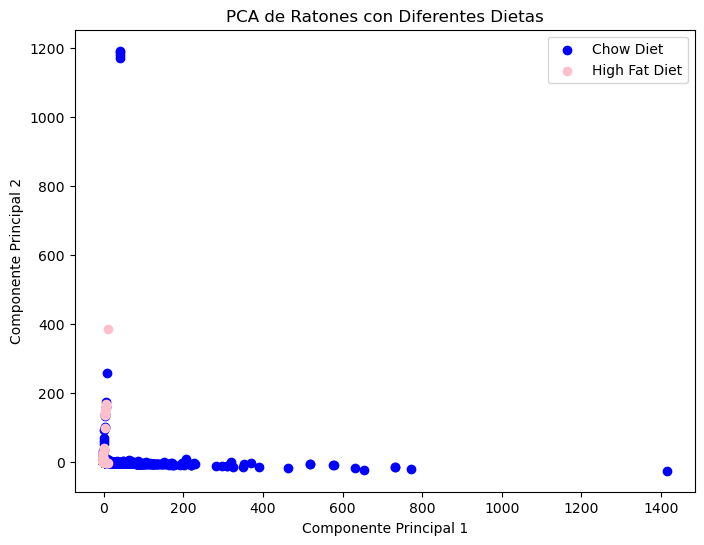

In [11]:
plt.figure(figsize=(8,6)) #tamaño estándar de las pantallas
for grupo, color in zip(['Chow Diet', 'High Fat Diet'], ['blue', 'pink']):
    indices = tags == grupo
    plt.scatter(pc[indices, 0], pc[indices, 1], c=color, label=grupo)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.title('PCA de Ratones con Diferentes Dietas')
plt.show()

Si descarto algunos outliners, se pueden apreciar 2 grupos bien diferenciados

Comprobado esto, realiza un dendograma

Para ello, creo un DataFrame que contenga los componentes principales

In [12]:
df_pca = pd.DataFrame(data = pc, columns = ['PC1', 'PC2'])

Gracias a este, ya puedo dibujar el dendograma o clustermap

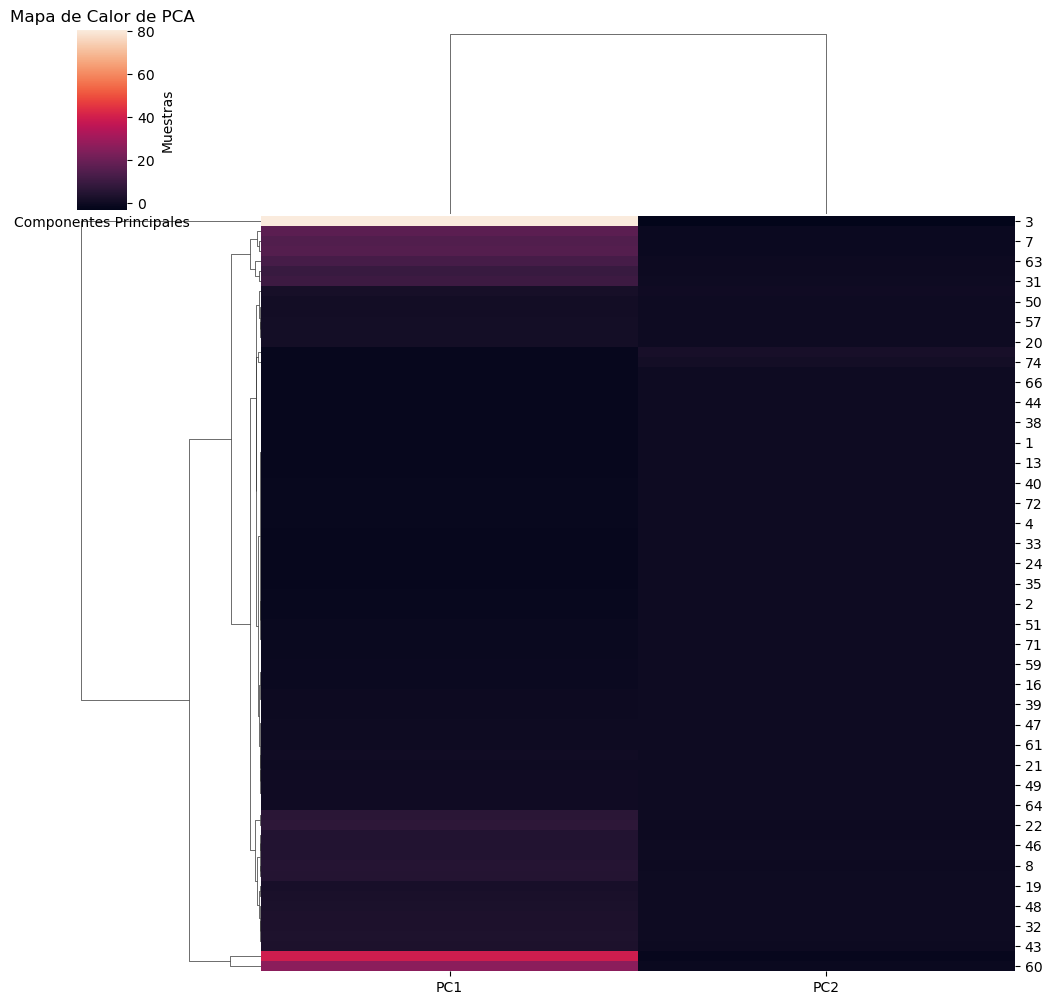

In [13]:
sns.clustermap(df_pca.head(75))
plt.title("Mapa de Calor de PCA")
plt.xlabel("Componentes Principales")
plt.ylabel("Muestras")
plt.show()